## 1. Setup and Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from transformers import (
    Sam3Processor, Sam3Model,
    AutoImageProcessor, AutoModelForDepthEstimation
)
import matplotlib

# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Image URL
CAT_URL = "http://images.cocodataset.org/val2017/000000077595.jpg"

Using device: cuda


## 2. Load Models

In [2]:
# Load SAM3 model and processor
print("Loading SAM3 model...")
sam3_model = Sam3Model.from_pretrained("facebook/sam3").to(device)
sam3_processor = Sam3Processor.from_pretrained("facebook/sam3")

# Load Depth Anything V2 model and processor
print("Loading Depth Anything V2 model...")
depth_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
depth_model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to(device)

print("Models loaded successfully!")

Loading SAM3 model...


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
Loading Depth Anything V2 model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading weights:   0%|          | 0/503 [00:00<?, ?it/s]

Models loaded successfully!


## 3. Load and Display Original Image

Image loaded successfully (Size: (640, 425))


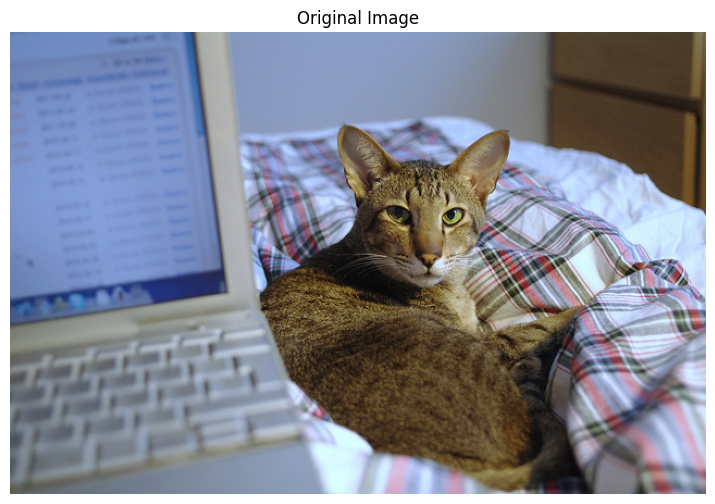

In [3]:
# Load the image
image = Image.open(requests.get(CAT_URL, stream=True).raw).convert("RGB")
print(f"Image loaded successfully (Size: {image.size})")

# Display original image
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

## 4. Segment Cat and Laptop using SAM3

In [4]:
def get_segment_mask(image, text_prompt, model, processor):
    """Get segmentation mask for a given text prompt"""
    inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Post-process results
    results = processor.post_process_instance_segmentation(
        outputs,
        threshold=0.5,
        mask_threshold=0.5,
        target_sizes=inputs.get("original_sizes").tolist()
    )[0]
    
    return results

# Segment cat and laptop
print("Segmenting cat...")
cat_results = get_segment_mask(image, "cat", sam3_model, sam3_processor)
print(f"Found {len(cat_results['masks'])} cat segments")

print("Segmenting laptop...")
laptop_results = get_segment_mask(image, "laptop", sam3_model, sam3_processor)
print(f"Found {len(laptop_results['masks'])} laptop segments")

Segmenting cat...
Found 1 cat segments
Segmenting laptop...
Found 1 laptop segments


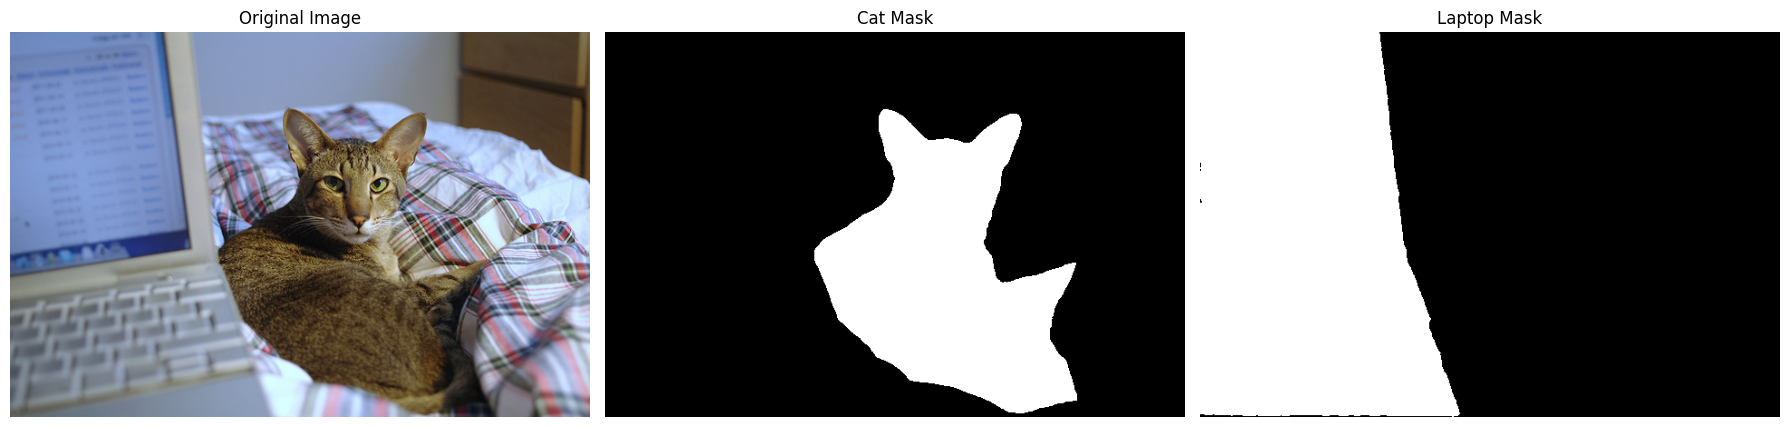

In [5]:
# Get combined masks
cat_mask = cat_results['masks'][0].cpu()
laptop_mask = laptop_results['masks'][0].cpu()

# Display segmentation results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

if cat_mask is not None:
    axes[1].imshow(cat_mask, cmap='gray')
    axes[1].set_title("Cat Mask")
else:
    axes[1].text(0.5, 0.5, 'No cat found', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title("Cat Mask (Not Found)")
axes[1].axis('off')

if laptop_mask is not None:
    axes[2].imshow(laptop_mask, cmap='gray')
    axes[2].set_title("Laptop Mask")
else:
    axes[2].text(0.5, 0.5, 'No laptop found', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title("Laptop Mask (Not Found)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 5. Generate Depth Map using Depth Anything V2

Generating depth map...
Depth map generated with shape: (425, 640)


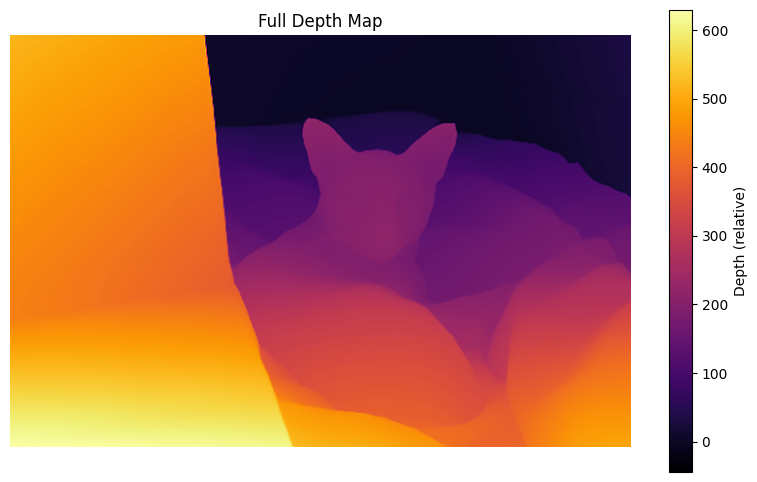

In [6]:
def get_depth_map(image, processor, model):
    """Generate depth map for the entire image"""
    # Prepare image for the model
    inputs = processor(images=image, return_tensors="pt").to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth
    
    # Interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.size[::-1],  # PIL image size is (W, H), interpolation expects (H, W)
        mode="bicubic",
        align_corners=False,
    )
    
    # Convert to numpy
    depth_map = prediction.squeeze().cpu().numpy()
    
    return depth_map

# Generate depth map for the entire image
print("Generating depth map...")
full_depth_map = get_depth_map(image, depth_processor, depth_model)
print(f"Depth map generated with shape: {full_depth_map.shape}")

# Display the full depth map
plt.figure(figsize=(10, 6))
plt.imshow(full_depth_map, cmap='inferno')
plt.title("Full Depth Map")
plt.colorbar(label='Depth (relative)')
plt.axis('off')
plt.show()

## 6. Combine Masks Function

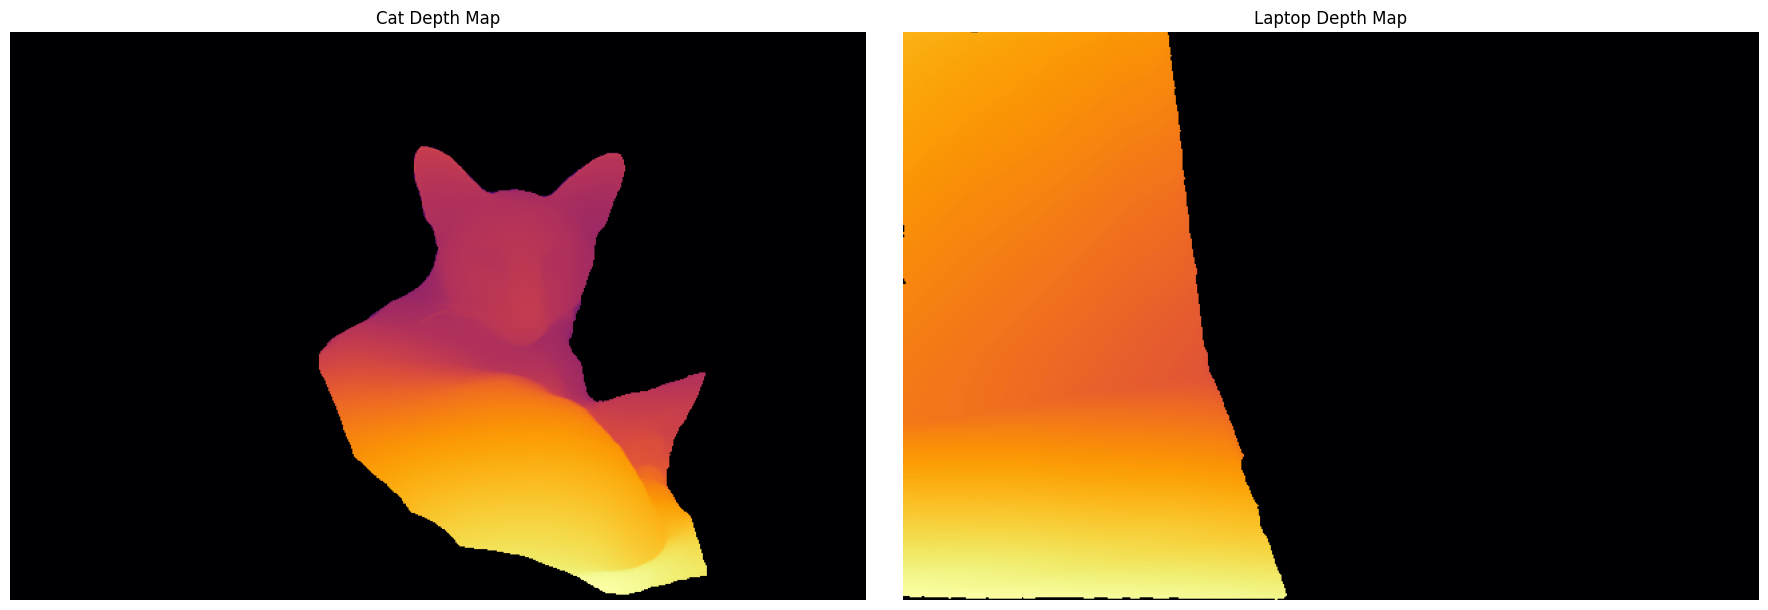

In [7]:
def apply_mask_to_depth(depth_map, mask):
    """Apply segmentation mask to depth map"""
    masked_depth = np.where(mask, depth_map, 0)  # Use NaN for masked out areas
    return masked_depth

# Apply masks to depth map
cat_depth_map = apply_mask_to_depth(full_depth_map, cat_mask.numpy())
laptop_depth_map = apply_mask_to_depth(full_depth_map, laptop_mask.numpy())
# Display masked depth maps
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].imshow(cat_depth_map, cmap='inferno')
axes[0].set_title("Cat Depth Map")
axes[0].axis('off')
axes[1].imshow(laptop_depth_map, cmap='inferno')
axes[1].set_title("Laptop Depth Map")
axes[1].axis('off')
plt.tight_layout()
plt.show()

## depth masks with image background

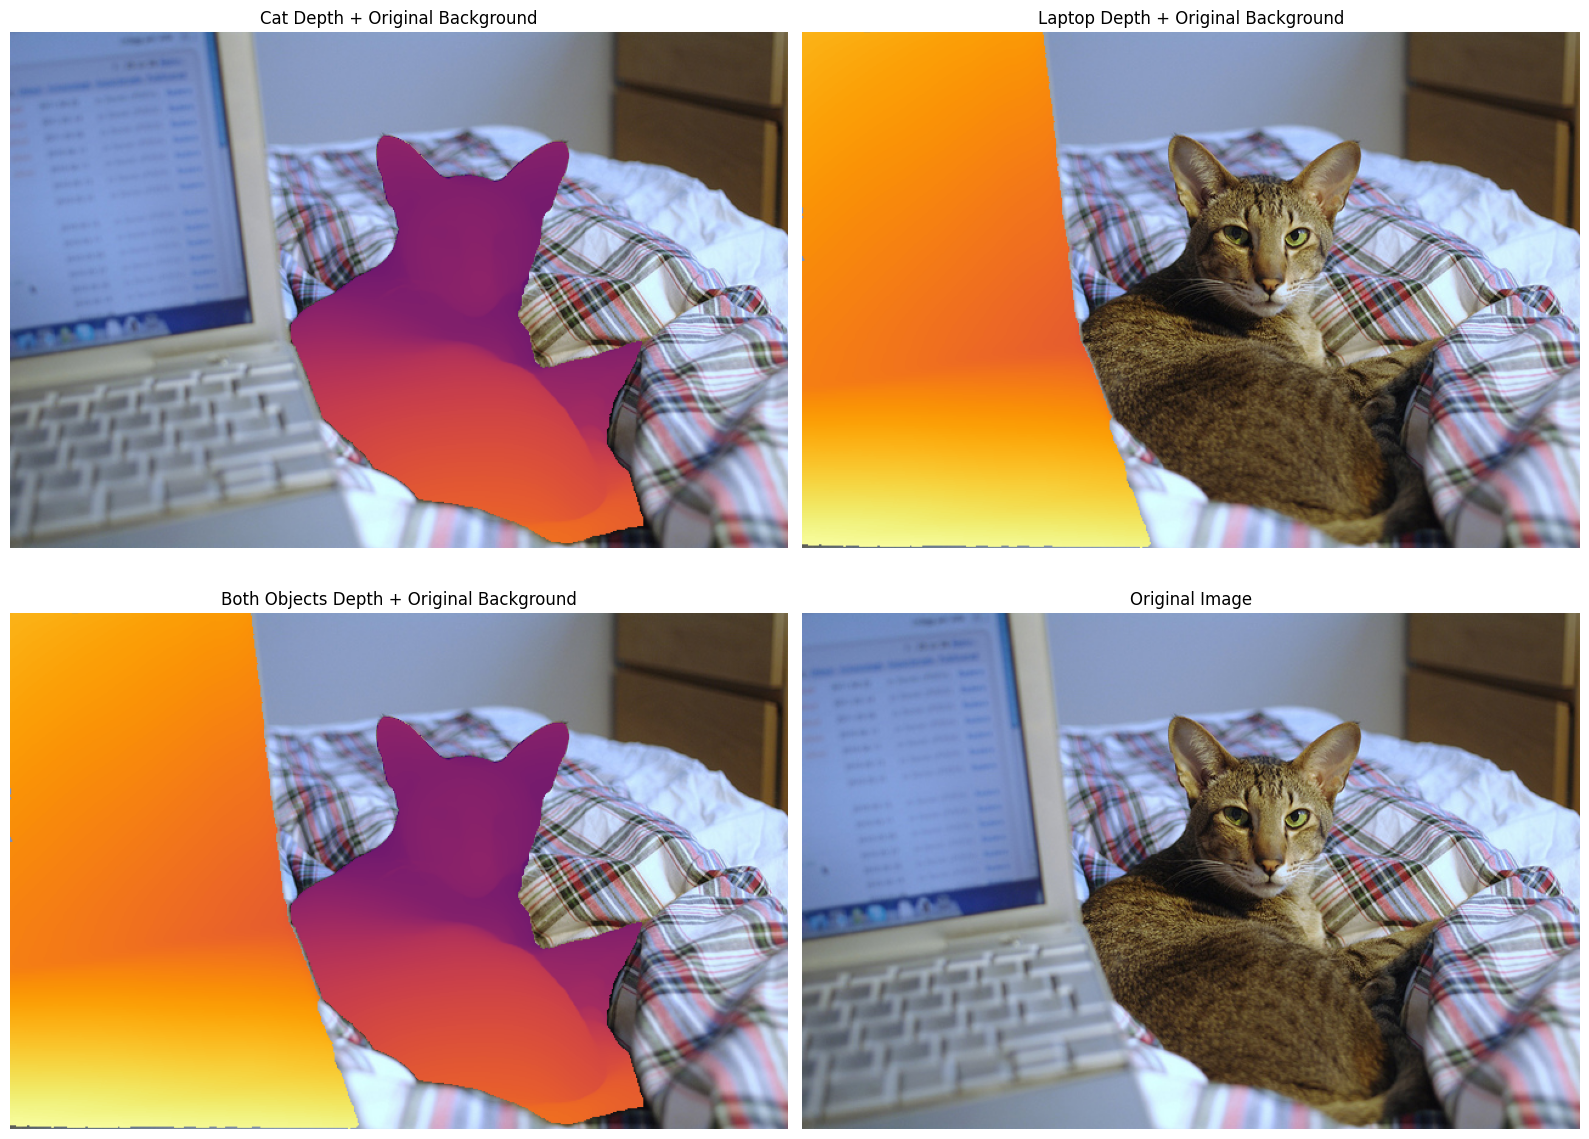

In [8]:
def create_depth_composite(image, depth_map, mask):
    """Apply segmentation mask to depth map with original image as background"""
    # Convert image to numpy array
    img_array = np.array(image)
    
    # Normalize depth map to 0-255 range
    depth_normalized = ((depth_map - depth_map.min()) / (depth_map.max() - depth_map.min()) * 255).astype(np.uint8)
    
    # Apply colormap to depth (inferno)
    cmap = plt.get_cmap('inferno')
    depth_colored = (cmap(depth_normalized / 255.0)[:, :, :3] * 255).astype(np.uint8)
    
    # Create composite: depth where mask is True, original image where mask is False
    mask_3d = np.stack([mask, mask, mask], axis=-1)  # Make mask 3D for RGB
    composite = np.where(mask_3d, depth_colored, img_array)
    
    return composite

# Create composite images with depth objects on original background
cat_composite = create_depth_composite(image, full_depth_map, cat_mask.numpy())
laptop_composite = create_depth_composite(image, full_depth_map, laptop_mask.numpy())

# Create combined composite with both objects
combined_mask = (cat_mask.numpy() | laptop_mask.numpy())
combined_composite = create_depth_composite(image, full_depth_map, combined_mask)

# Display composites
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].imshow(cat_composite)
axes[0, 0].set_title("Cat Depth + Original Background")
axes[0, 0].axis('off')

axes[0, 1].imshow(laptop_composite)
axes[0, 1].set_title("Laptop Depth + Original Background")
axes[0, 1].axis('off')

axes[1, 0].imshow(combined_composite)
axes[1, 0].set_title("Both Objects Depth + Original Background")
axes[1, 0].axis('off')

axes[1, 1].imshow(image)
axes[1, 1].set_title("Original Image")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()